In [3]:
from tensorflow.python.client import device_lib

def get_available_devices():  
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/cpu:0', '/gpu:0', '/gpu:1', '/gpu:2']


In [1]:
from keras.layers import Input, Dense
from keras.models import Model

# NEW ADDED FOR THIS BOOK
from keras import regularizers

Using TensorFlow backend.


(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 0s - loss: 0.6840 - val_loss: 0.6606
Epoch 2/50
60000/60000 [==============================] - 0s - loss: 0.6439 - val_loss: 0.6272
Epoch 3/50
60000/60000 [==============================] - 0s - loss: 0.6111 - val_loss: 0.5952
Epoch 4/50
60000/60000 [==============================] - 0s - loss: 0.5801 - val_loss: 0.5655
Epoch 5/50
60000/60000 [==============================] - 0s - loss: 0.5518 - val_loss: 0.5386
Epoch 6/50
60000/60000 [==============================] - 0s - loss: 0.5263 - val_loss: 0.5145
Epoch 7/50
60000/60000 [==============================] - 0s - loss: 0.5036 - val_loss: 0.4932
Epoch 8/50
60000/60000 [==============================] - 1s - loss: 0.4835 - val_loss: 0.4743
Epoch 9/50
60000/60000 [==============================] - 1s - loss: 0.4658 - val_loss: 0.4577
Epoch 10/50
60000/60000 [==============================] - 0s - loss:

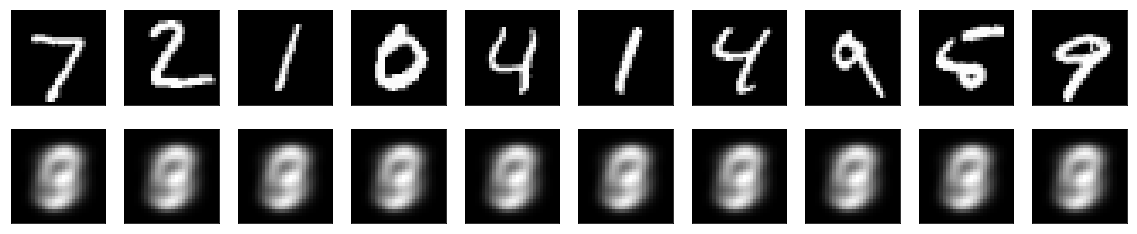

In [7]:
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as sess:
    # this is the size of our encoded representations
    encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

    # this is our input placeholder
    input_img = Input(shape=(784,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu',
                   activity_regularizer =regularizers.l1(10e-5))(input_img) #-># NEW ADDED FOR THIS BOOK
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(784, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    
    # SEPERATE ENCODER MODEL
    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)
    
    # SEPERATE DECODER MODEL
    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    #First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    # INPUT DATA. 
    #We're using MNIST digits, and we're discarding the labels 
    #(since we're only interested in encoding/decoding the input images).

    from keras.datasets import mnist
    import numpy as np
    (x_train, _), (x_test, _) = mnist.load_data()
    
    # We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    print (x_train.shape)
    print (x_test.shape)


    # len(x_train) # -> 60000
    # x_train.shape[1:] #-> (28, 28)
    # np.prod(x_train.shape[1:]) #-> 784
    # x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    # x_train.shape #-> (60000, 784)
    
    autoencoder.fit(x_train, x_train,
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))
    
     # encode and decode some digits
    # note that we take them from the *test* set
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    # use Matplotlib (don't ask)
    import matplotlib.pyplot as plt

    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()